In [1]:
%%capture
from scipy.optimize import minimize 
%run EOMs.ipynb
%matplotlib inline

True poincaire sections at constant H would allow us to get a picture of system dynamics as a function of H, which varies adiabatically in the dissipative capture process.

# Symbols & expressions

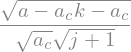

In [2]:
ac = symbols("a_c",positive=True)
H_simp_expr = (
    -Rational(3, 4) * (j + 1) * (j + om / np) * e**4
    - Rational(3, 2) * k * (j + om / np) * e**2
    - 2 * b * sqrt(ap / ac) * mup * e * cos(th)
)
H_simp_expr
H_simp_expr.free_symbols
k_expr = (a-ac)/ac - (j+1)*e**2
Eq(k,k_expr)
solve(Eq(k,k_expr),e)
e_expr_a_k = solve(Eq(k,k_expr),e)[1]
e_expr_a_k

# Poincaire Sections for constant H

THESE ARE NOT CONSTANT ENERGY EITHER BECAUSE GAMMA GOES INTO DENOMINATOR WHERE LAMBDA IS

Wait, no, it only comes in as J1+J2 = Lambda/(j+1)

NO IT DOES COME IN FROM THE d/dt PART!!!!!

 I can';t fucking figure this out. It's a complete mystery. it does not do anyhthing that i expect. at every turn, a disaster. nothing even remotely resembling a poincaire section has come out of this multi-day slog. i am defeated.

In [3]:
%matplotlib inline

In [4]:
T_INTEG = 1e4
np_sel = 1.
ap_sel = np_sel**(-2./3)
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 0,  # 12.08476062046314,
    b2_3_2: 0,  # 10.485706741948807,
    ep: 0.1,
    om: 0,
    omp: 0,
    np:np_sel,
    ap:ap_sel,
    "th0":npy.pi,
    "thp0":0,
}
nc_sel = (params[j]*np_sel + params[om])/(params[j]+1)
params[ac] = nc_sel**(-2./3)

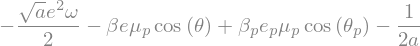

In [5]:
H_expr = - 1/(2*a) - Rational(1,2)*sqrt(a)*e**2*om + mup*bp*ep*cos(thp) - mup*b*e*cos(th) #- omp*(sqrt(a)/(j+1)-Rational(1,2)*sqrt(a)*e**2) #- j*np*sqrt(a)/(j+1)
H_expr

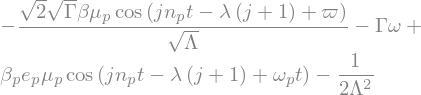

In [6]:
H_expr = H_expr.subs({
    Rational(1,2)*sqrt(a)*e**2: Gam,
    e: sqrt(2*Gam/Lam),
    sqrt(a): Lam,
    thp: (j+1)*l-j*np*t-omp*t,
    th: (j+1)*l-j*np*t-pom,
})
#H_expr = H_expr.subs(b/sqrt(Lam),b/sqrt(a0))
H_expr

In [7]:
J, Jp = symbols("J J_p")

In [8]:
S1_expr = Jp*((j+1)*l-j*np*t-omp*t) + J*((j+1)*l-j*np*t-pom)
S1_expr

In [9]:
Lam1_expr = S1_expr.diff(l)
Gam1_expr = -S1_expr.diff(pom)
th1_expr = S1_expr.diff(J)
thp1_expr = S1_expr.diff(Jp)
display(Lam1_expr)
display(Gam1_expr)
display(th1_expr)
display(thp1_expr)

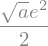

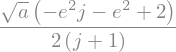

In [10]:
J_expr = solve(Gam-Gam1_expr,J)[0].subs({Gam:Rational(1,2)*sqrt(a)*e**2})
Jp_expr = solve(Lam-Lam1_expr,Jp)[0].subs({J:J_expr}).subs({Gam:Rational(1,2)*sqrt(a)*e**2,Lam:sqrt(a)}).simplify()
display(J_expr)
display(Jp_expr)

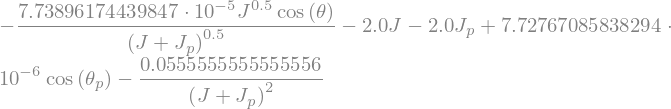

In [11]:
H1_expr = H_expr.subs({Lam:Lam1_expr,Gam:Gam1_expr,th1_expr:th,thp1_expr:thp}) + S1_expr.diff(t)
H1_expr = H1_expr.subs(params).evalf()#.subs({J:J_expr,Jp:Jp_expr})
H1_expr

In [12]:
funcs = lambdify(
    [th, thp, J, Jp],
    [
        H1_expr.diff(J),
        H1_expr.diff(Jp),
        -H1_expr.diff(th),
        -H1_expr.diff(thp),
    ],
    "numpy",
)
def func(t, x0):
    return funcs(x0[0],x0[1],x0[2],x0[3])

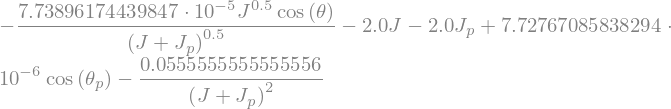

In [35]:
_ = H1_expr.subs(params)#.subs({th:params["th0"],thp:params["thp0"]})#.subs({J:0.018,Jp:0.3613})
display(_)
_ = lambdify([th, thp, J, Jp], _)

In [142]:
th0val = npy.pi
thpval = 0
Hval = -1.1447201
Jval = 0.00000001

Jpval = brentq(lambda x: _(th0val, thpval, Jval, x)-Hval, 0,0.382,xtol=1e-16)

initconds = [
    th0val,
    thpval,
    Jval,
    Jpval,
]
print(initconds)
print(_(th0val, thpval, Jval, Jpval))

[3.141592653589793, 0, 1e-08, 0.3802593193728349]
-1.1447201


In [143]:
#_lvl = Hval
#
#_1 = lambdify([thp,Jp], H1_expr.subs({th: th0val, J: 0.017}).subs(params).evalf())
#_2,_3= npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(0.36,0.37,1000))
#plt.clf()
#cs = plt.contour(_2,_3,_1(_2,_3))#,levels=[_lvl,_lvl*0.999999])
#plt.colorbar(cs)
#plt.show()
#
#_1 = lambdify([th,J], H1_expr.subs({thp: thpval, Jp: Jpval}).subs(params).evalf())
#_2,_3= npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(0,0.006,1000))
#plt.clf()
#cs = plt.contour(_2,_3,_1(_2,_3))
#plt.colorbar(cs)
#plt.show()

In [155]:
print(func(0,initconds))

def section_thp(t, x0):
    return npy.sin(x0[1])

def section_th(t, x0):
    return npy.sin(x0[0])

section_thp.direction = 1
section_th.direction = 1

teval = npy.linspace(0, 2 * npy.pi * 1e6, 10000)
sol = sp.integrate.solve_ivp(
    func,
    [teval[0], teval[-1]],
    initconds,
    t_eval=teval,
    rtol=1e-12,
    atol=1e-12,
    method="DOP853",
    events=[section_thp, section_th],
)

[0.6482731070693339, 0.0207745012928231, -1.5369283180672602e-24, 0.0]


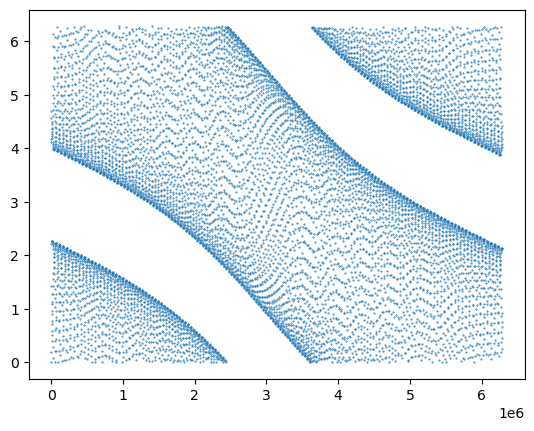

In [157]:
plt.clf()
#plt.scatter(sol.t,sol.y[0,:]%(2*npy.pi),s=0.2)
plt.scatter(sol.t,sol.y[1,:]%(2*npy.pi),s=0.2)
#plt.scatter(sol.t,sol.y[2,:],s=0.2)
#plt.scatter(sol.t,_(sol.y[0,:],sol.y[1,:],sol.y[2,:],sol.y[3,:],))
plt.show()

In [29]:
H10 = (
    H1_expr.subs({th: params["th0"], thp: params["thp0"], J: 0.020255, Jp: 0.3613})
    .subs(params)
    .evalf()
)
H10

In [30]:
#Jval = 0.0203
#_ = H1_expr.subs({J:Jval,th:params["th0"],thp:params["thp0"]})-H10
#display(_)
#_f = lambdify([Jp],_)
#_1 = npy.linspace(0.3,0.4)
#plt.clf()
#plt.plot(_1,_f(_1))
#plt.axhline(y=0)
#plt.show()

In [31]:
def section_thp(t, x0):
    return ((x0[1]+npy.pi) % (2*npy.pi) - npy.pi) 

def section_th(t, x0):
    return (x0[0]+npy.pi) % (2*npy.pi) - npy.pi

#section_thp.direction = -1
#section_th.direction = 1

    #0.020255,
    #0.3613

jit = 0
Jvals = [_ for _ in npy.linspace(0.020255,0.1,10)]
Jpvals = []
for Jval in Jvals:
    _ = H1_expr.subs({J:Jval,th:params["th0"],thp:params["thp0"]})-H10
    #display(_)
    _f = lambdify([Jp],_)
    search_intervals = npy.linspace(0.25,0.4,100000)
    _ = []
    for i in range(len(search_intervals)-1):
        try:
            _ += [brentq(_f,search_intervals[i],search_intervals[i+1],xtol=1e-18)]
        except ValueError:
            pass
    print(_)
    Jpvals += [max(_)]

[0.35875259662357756, 0.3612999999998147]
[0.34654101448412084, 0.3558490006881224]
[0.3360049279530385, 0.3487196954984794]
[0.3258916374306353, 0.34116573142785556]
[0.3159985666567323, 0.3333901957168448]
[0.3062451339789418, 0.32547398293992486]
[0.2965897956211675, 0.31745884499293364]
[0.287007928614812, 0.3093695515716263]
[0.2774835775320804, 0.30122216614815517]
[0.2680057361211174, 0.2930277772663217]


In [32]:
[sqrt(_*2/sqrt(params["a0"])) for _ in Jvals]

In [33]:
sols = []
jit = 0
for Jpval, Jval in zip(Jpvals, Jvals):
    display(
        H1_expr.subs({th: params["th0"], thp: params["thp0"], J: Jval, Jp: Jpval})
        .subs(params)
        .evalf()
    )
    jit += 1
    initconds = [
        params["th0"],
        params["thp0"],
        Jval,
        Jpval,
    ]
    teval = npy.linspace(0, 2 * npy.pi * 1e4, 10000)
    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        initconds,
        t_eval=teval,
        rtol=1e-9,
        atol=1e-9,
        method="DOP853",
        events=[section_thp, section_th],
    )
    sols += [sol]

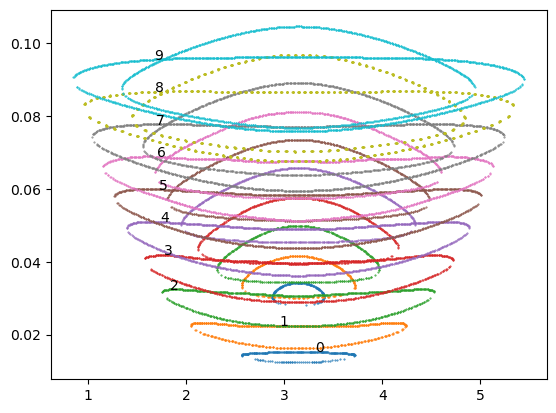

In [34]:
plt.clf()
jit = 0
for sol in sols:
    ev = sol.y_events[0]
    te = sol.t_events[0]
    #ev = sol.y_events[1]
    #te = sol.t_events[1]

    X = ev[:,0] % (2*npy.pi)
    Y = ev[:,2]
    #X = ev[:,1] % (2*npy.pi)
    #Y = ev[:,3]

    plt.scatter(X,Y,s=0.2)
    plt.text(X[0],Y[0],jit)

    jit += 1
plt.show()

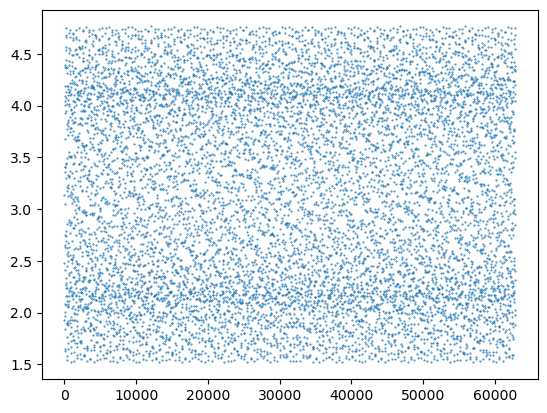

In [35]:
plt.clf()
jit = 3
#plt.scatter(sols[0].t_events[0],sols[0].y_events[0][:,0]%(2*npy.pi),s=0.2)
plt.scatter(sols[jit].t,sols[jit].y[0,:]%(2*npy.pi),s=0.2)
plt.show()